In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled.")
    except RuntimeError as e:
        print("RuntimeError:", e)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten,MaxPool2D,Conv2D

In [9]:
import glob
import os
import warnings
warnings.filterwarnings('ignore')

In [10]:
path=r"C:\Users\Arun\Documents\Scaler\Computer Vision\Dog VS Cat\PetImages"

# We need to check whether the image is empty or corrupted

In [ ]:
full_path=[]
for filename in os.listdir(path):
    file_paths = glob.glob(f'C:/Users/Arun/Documents/Scaler/Computer Vision/Dog VS Cat/PetImages/{filename}/*')
    full_path.extend(file_paths)

In [ ]:
invalid_images = []
for image_path in full_path:
    try:
            # Read the image file
        img = tf.io.read_file(image_path)
            
            # Try decoding the image (use decode_png for PNG images)
        img = tf.image.decode_jpeg(img, channels=3)  # Use decode_png for PNG files

            # Optionally, check for invalid images with zero height or width
        if img.shape[0] == 0 or img.shape[1] == 0:
            invalid_images.append(image_path)
        
    except tf.errors.InvalidArgumentError:
            # If there is a decoding error, it's an invalid image
        invalid_images.append(image_path)

In [ ]:
def remove_invalid_images(invalid_images):
    for img_path in invalid_images:
        os.remove(img_path)
        print(f"Removed: {img_path}")

In [ ]:
remove_invalid_images(invalid_images)

In [11]:
batch=32

In [173]:
train_ds=tf.keras.utils.image_dataset_from_directory(path,validation_split=0.2,subset="training",seed=123,batch_size=batch,image_size=(224,224))

Found 24823 files belonging to 2 classes.
Using 19859 files for training.


In [174]:
train_ds.class_names

['Cat', 'Dog']

In [175]:
validation_ds=tf.keras.utils.image_dataset_from_directory(path,validation_split=0.2,subset="validation",seed=123,batch_size=batch,image_size=(224,224))

Found 24823 files belonging to 2 classes.
Using 4964 files for validation.


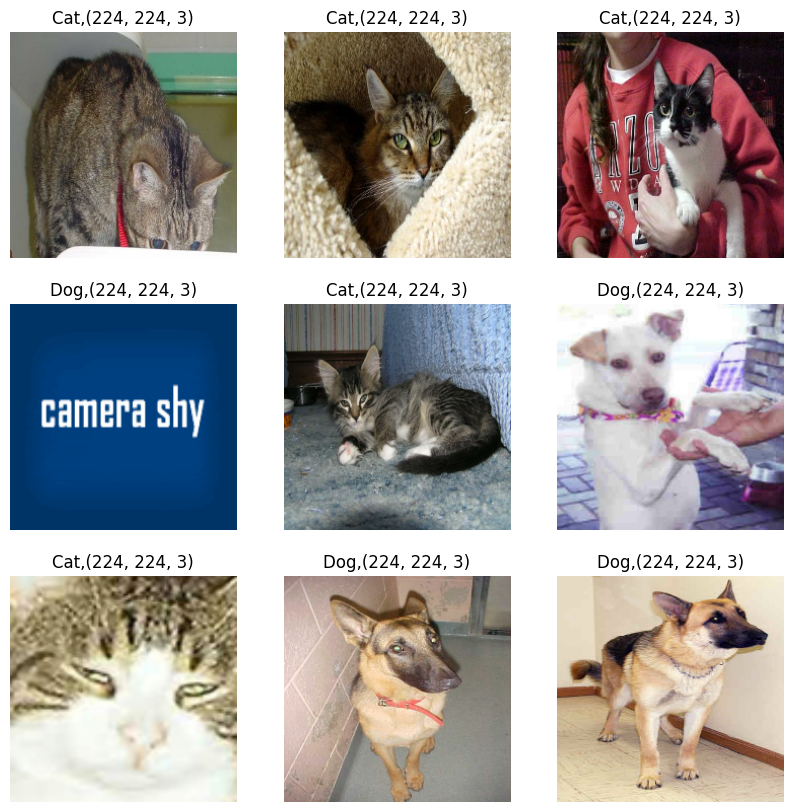

In [176]:
class_name=train_ds.class_names
plt.figure(figsize=(10,10))
for image,label in train_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        # plt.title(image[i].shape)
        plt.title(f"{class_name[label[i]]},{image[i].shape}")
        plt.axis("off")


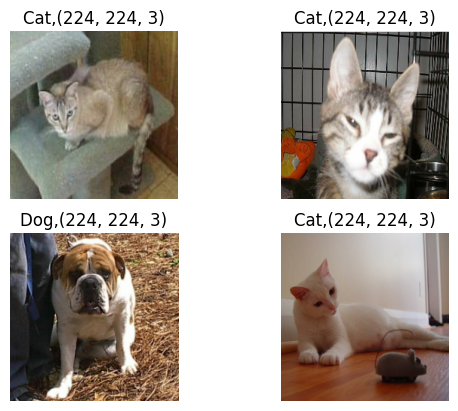

In [177]:
validation_ds_class_name=validation_ds.class_names
for image,label in validation_ds.take(1):
    for i in range(4):
        ax=plt.subplot(2,2,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(f"{validation_ds_class_name[label[i]]},{image[i].shape}")
        plt.axis("off")

# Data Preprocessing

In [178]:
data_preprocessing=tf.keras.Sequential(
                                       [#layers.RandomFlip("horizontal_and_vertical"),
                                        #layers.RandomRotation(0.2),
                                        #layers.RandomZoom(0.2),
                                        #layers.RandomContrast(0.2),
                                        layers.Rescaling(1.0/255)],name="Image_Processing_augmentation")

In [179]:
train=train_ds.map(lambda x, y: (data_preprocessing(x), y))

In [180]:
validation=validation_ds.map(lambda x, y: (data_preprocessing(x), y))

# Basic Sequential model

In [181]:
base_model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224,224,3)),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",
                           activation="relu"),
    tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same",
                           activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=(2,2)),

    tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding="same",
                           activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=(2,2)),
    
    tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),padding="same",
                           activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=(2,2)),

    tf.keras.layers.Conv2D(filters=512,kernel_size=(3,3),padding="same",
                           activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2),strides=(2,2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=64,activation="relu"),
    tf.keras.layers.Dense(units=1,activation='sigmoid')
])

In [182]:
base_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_16 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 56, 56, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 56, 56, 256)      

In [183]:
base_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [184]:
base_model_history=base_model.fit(train,epochs=5,validation_data=validation,verbose=1)

Epoch 1/5
621/621 [==============================] - 128s 203ms/step - loss: 0.6954 - accuracy: 0.5176 - val_loss: 0.6844 - val_accuracy: 0.5747
Epoch 2/5
621/621 [==============================] - 122s 196ms/step - loss: 0.6846 - accuracy: 0.5607 - val_loss: 0.6828 - val_accuracy: 0.5528
Epoch 3/5
621/621 [==============================] - 122s 197ms/step - loss: 0.6643 - accuracy: 0.6076 - val_loss: 0.6479 - val_accuracy: 0.6600
Epoch 4/5
621/621 [==============================] - 122s 197ms/step - loss: 0.6268 - accuracy: 0.6663 - val_loss: 0.6020 - val_accuracy: 0.6996
Epoch 5/5
621/621 [==============================] - 122s 197ms/step - loss: 0.5677 - accuracy: 0.7276 - val_loss: 0.5875 - val_accuracy: 0.7190


In [185]:
def train_plot(metrics,model_trained):
    
    f,ax=plt.subplots(1,len(metrics),figsize=(10,6))
    for idx,metric in enumerate(metrics):
        ax[idx].plot(model_trained.history[metric],ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(model_trained.history['val_' + metric]);
        ax[idx].legend([metric, 'val_' + metric])

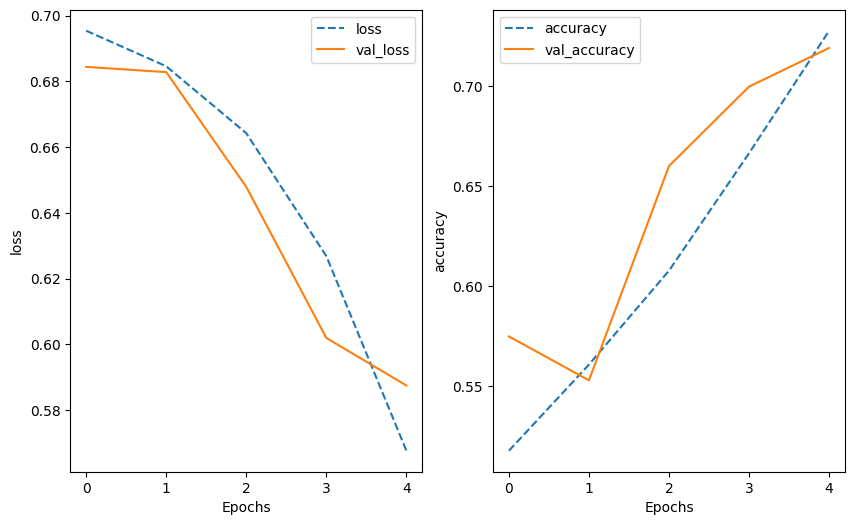

In [191]:
train_plot(['loss','accuracy'],base_model_history)

# Still we can go for more epoch

In [193]:
os.listdir(test_path)

['cat3.jpg', 'cat4.jpg', 'dog1.jpg', 'dog2.jpg']

In [195]:
loss, acc = base_model.evaluate(validation, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

156/156 - 16s - loss: 0.5875 - accuracy: 0.7190 - 16s/epoch - 103ms/step
Restored model, accuracy: 71.90%


1/1 [==============================] - 0s 36ms/step


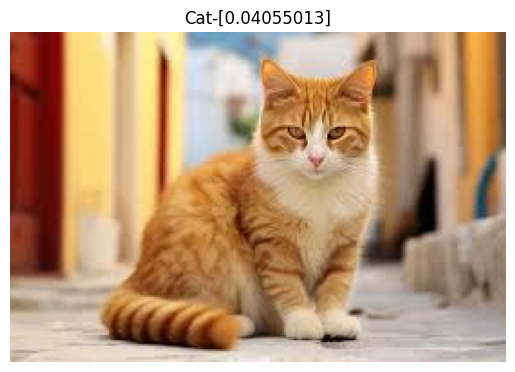

1/1 [==============================] - 0s 23ms/step


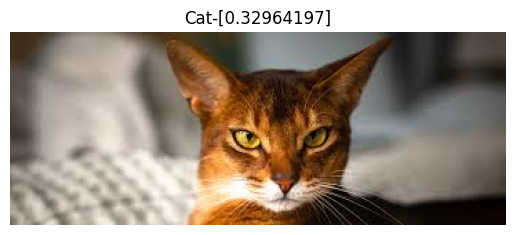

1/1 [==============================] - 0s 21ms/step


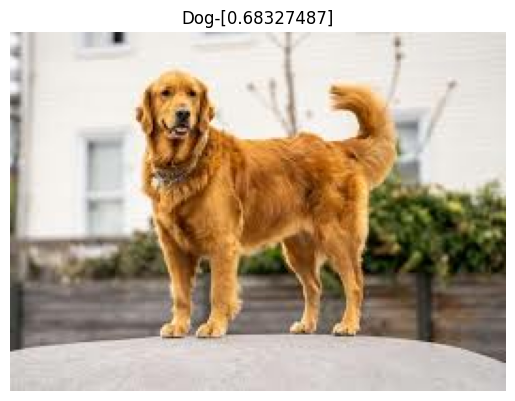

1/1 [==============================] - 0s 22ms/step


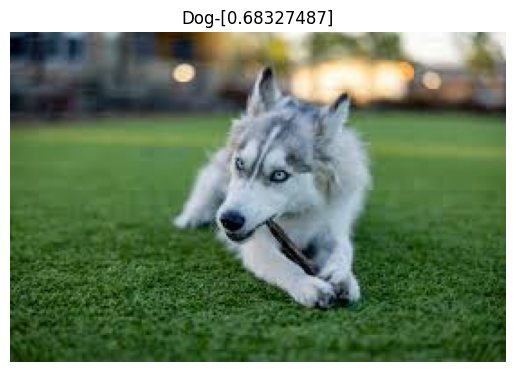

In [235]:
test_path=r"C:\Users\Arun\Documents\Scaler\Computer Vision\Dog VS Cat\test"
for i in os.listdir(test_path):
    path=f'C:\\Users\\Arun\\Documents\\Scaler\\Computer Vision\\Dog VS Cat\\test\\{i}'
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    plt.imshow(image)
    plt.axis("off")
    image = tf.image.resize(image, size=(224, 224))
    image = image / 255.0
    image = tf.expand_dims(image, axis=0) 
    y_pred=base_model.predict(image)
    ind=1 if y_pred[0] >= 0.5 else 0
    plt.title(f'{train_ds.class_names[ind]}-{y_pred[0]}')
    plt.show()
    

In [236]:
pre_trained=tf.keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=[224,224,3])

94765736/94765736 [==============================] - 6s 0us/step


In [237]:
pre_trained.trainable=False

In [246]:
model= tf.keras.Sequential([pre_trained,
                            layers.Conv2D(64,kernel_size=(1,1),activation='relu'),
                            layers.GlobalAveragePooling2D(),
                            layers.Dense(64,activation='relu'),
                            layers.Dense(units=1,activation='sigmoid')])

In [247]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d_22 (Conv2D)          (None, 7, 7, 64)          131136    
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 23,723,073
Trainable params: 135,361
Non-trainable params: 23,587,712
____________________________________

In [248]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [249]:
model_history=model.fit(train,epochs=5,validation_data=validation,verbose=1)

Epoch 1/5
621/621 [==============================] - 110s 172ms/step - loss: 0.6592 - accuracy: 0.6038 - val_loss: 0.6405 - val_accuracy: 0.6243
Epoch 2/5
621/621 [==============================] - 110s 178ms/step - loss: 0.6330 - accuracy: 0.6376 - val_loss: 0.6582 - val_accuracy: 0.5782
Epoch 3/5
621/621 [==============================] - 113s 181ms/step - loss: 0.6165 - accuracy: 0.6603 - val_loss: 0.5980 - val_accuracy: 0.6743
Epoch 4/5
621/621 [==============================] - 111s 179ms/step - loss: 0.5913 - accuracy: 0.6822 - val_loss: 0.5745 - val_accuracy: 0.7041
Epoch 5/5
621/621 [==============================] - 115s 184ms/step - loss: 0.5879 - accuracy: 0.6857 - val_loss: 0.5945 - val_accuracy: 0.6743


In [250]:
loss, acc = model.evaluate(validation, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

156/156 - 25s - loss: 0.5945 - accuracy: 0.6743 - 25s/epoch - 158ms/step
Restored model, accuracy: 67.43%


1/1 [==============================] - 1s 1s/step


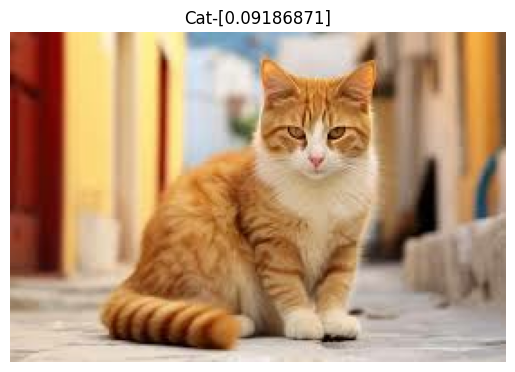

1/1 [==============================] - 0s 34ms/step


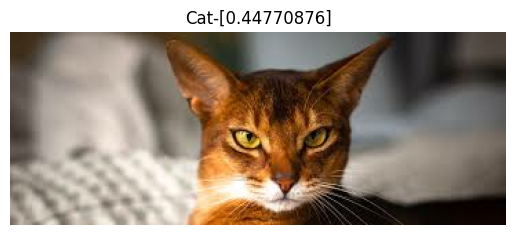

1/1 [==============================] - 0s 27ms/step


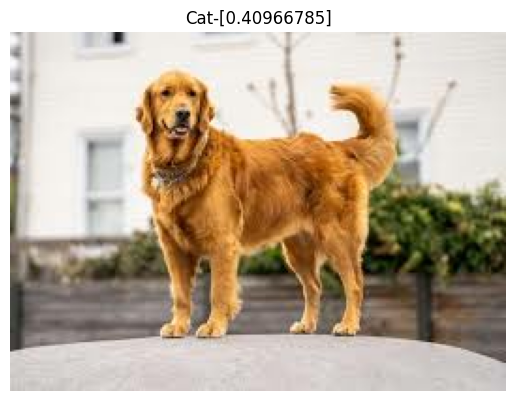

1/1 [==============================] - 0s 28ms/step


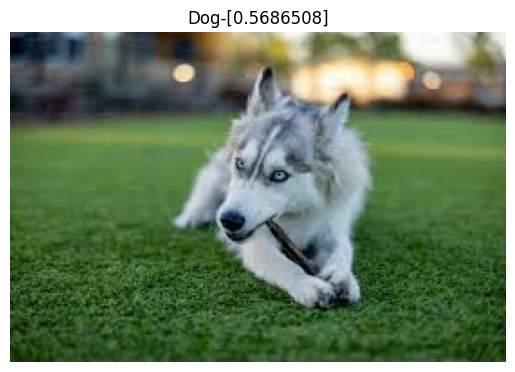

In [251]:
test_path=r"C:\Users\Arun\Documents\Scaler\Computer Vision\Dog VS Cat\test"
for i in os.listdir(test_path):
    path=f'C:\\Users\\Arun\\Documents\\Scaler\\Computer Vision\\Dog VS Cat\\test\\{i}'
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    plt.imshow(image)
    plt.axis("off")
    image = tf.image.resize(image, size=(224, 224))
    image = image / 255.0
    image = tf.expand_dims(image, axis=0) 
    y_pred=model.predict(image)
    ind=1 if y_pred[0] >= 0.5 else 0
    plt.title(f'{train_ds.class_names[ind]}-{y_pred[0]}')
    plt.show()